<a href="https://colab.research.google.com/github/kjedrzejczak/Wprowadzenie_do_sieci_neuronowych-Tensorflow_2.0-Keras/blob/main/25_Model_transfer_learning_VGG19(wieloklasowa_VGG19_4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19

np.set_printoptions(suppress=True, precision=6)

In [2]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
!unzip -q flying-vehicles.zip

--2024-07-01 16:43:37--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G  25.7MB/s    in 60s     

2024-07-01 16:44:38 (24.5 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



In [3]:
!rm -rf ./images

In [4]:
"""Sprawdzanie ilości plików w każdej kategorji"""
base_dir = './data/planes'
raw_no_of_files = {}
for i in ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']:
  raw_no_of_files[i] = len(os.listdir(os.path.join(base_dir, i)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [5]:
"""👉tworzenie struktury katalogów👈"""

data_dir = './images'   # katalog główny

if not os.path.exists(data_dir):
  os.mkdir(data_dir)


train_dir = os.path.join(data_dir, 'train')  # podkatalog
valid_dir = os.path.join(data_dir, 'valid')  # podkatalog
test_dir = os.path.join(data_dir, 'test')    # podkatalog


for i in [train_dir, valid_dir, test_dir]:
  if not os.path.exists(i):
    os.mkdir(i)

train_drone_dir = os.path.join(train_dir, 'drone') # podkatalog --> podgatalog
valid_drone_dir = os.path.join(valid_dir, 'drone') # podkatalog --> podgatalog
test_drone_dir = os.path.join(test_dir, 'drone')   # podkatalog --> podgatalog


train_passenger_dir = os.path.join(train_dir, 'passenger')  # podkatalog --> podgatalog
valid_passenger_dir = os.path.join(valid_dir, 'passenger')  # podkatalog --> podgatalog
test_passenger_dir = os.path.join(test_dir, 'passenger')    # podkatalog --> podgatalog


train_helicopter_dir = os.path.join(train_dir, 'helicopter')  # podkatalog --> podgatalog
valid_helicopter_dir = os.path.join(valid_dir, 'helicopter')  # podkatalog --> podgatalog
test_helicopter_dir = os.path.join(test_dir, 'helicopter')    # podkatalog --> podgatalog


for i in [train_drone_dir, valid_drone_dir, test_drone_dir,
          train_passenger_dir, valid_passenger_dir, test_passenger_dir,
          train_helicopter_dir, valid_helicopter_dir, test_helicopter_dir ]:
  if not os.path.exists(i):
    os.mkdir(i)

In [6]:
"""👉kopiowanie plików do katalogów👈"""
base_dir = './data/planes'

drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))                  # sprawdzić i podać nazwy rozpakowanych katalogów
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))    # sprawdzić i podać nazwy rozpakowanych katalogów
helicopter_fnames = os.listdir(os.path.join(base_dir, 'helicopter'))        # sprawdzić i podać nazwy rozpakowanych katalogów


"""👉weryfikacj nazw danych👈"""
drone_fnames = [i for i in drone_fnames if i.split('.')[1] in ['jpg', 'png', 'jpeg']]
passenger_fnames = [i for i in passenger_fnames if i.split('.')[1] in ['jpg', 'png', 'jpeg']]
helicopter_fnames = [i for i in helicopter_fnames if i.split('.')[1] in ['jpg', 'png', 'jpeg']]

In [7]:
print(len(drone_fnames))
print(len(passenger_fnames))
print(len(helicopter_fnames))

1290
1399
1333


In [8]:
"""👉podziłą plików na 0.7->train, 0.2->valid, 0.1->test👈"""


size = min(len(drone_fnames), len(passenger_fnames), len(helicopter_fnames))  # min dla trzech klass - eleminacja IndexError👌

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

"""👉kopionwanie na podstawie numery indeksu👈"""
train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size


for i , fname in enumerate(drone_fnames):
  if i <= train_idx:
    source = os.path.join(base_dir, 'drone', fname)
    destination = os.path.join(train_drone_dir, fname)
    shutil.copyfile(source, destination)
  elif train_idx < i <= valid_idx:
    source = os.path.join(base_dir, 'drone', fname)
    destination = os.path.join(valid_drone_dir, fname)
    shutil.copyfile(source, destination)
  elif valid_idx < i < test_idx:
    source = os.path.join(base_dir, 'drone', fname)
    destination = os.path.join(test_drone_dir, fname)
    shutil.copyfile(source, destination)


for i , fname in enumerate(passenger_fnames):
  if i <= train_idx:
    source = os.path.join(base_dir, 'passenger-plane',  fname)
    destination = os.path.join(train_passenger_dir, fname)
    shutil.copyfile(source, destination)
  elif train_idx < i <= valid_idx:
    source = os.path.join(base_dir, 'passenger-plane', fname)
    destination = os.path.join(valid_passenger_dir, fname)
    shutil.copyfile(source, destination)
  elif valid_idx < i < test_idx:
    source = os.path.join(base_dir, 'passenger-plane', fname)
    destination = os.path.join(test_passenger_dir, fname)
    shutil.copyfile(source, destination)


for i , fname in enumerate(helicopter_fnames):
  if i <= train_idx:
    source = os.path.join(base_dir, 'helicopter', fname)
    destination = os.path.join(train_helicopter_dir, fname)
    shutil.copyfile(source, destination)
  elif train_idx < i <= valid_idx:
    source = os.path.join(base_dir, 'helicopter', fname)
    destination = os.path.join(valid_helicopter_dir, fname)
    shutil.copyfile(source, destination)
  elif valid_idx < i < test_idx:
    source = os.path.join(base_dir, 'helicopter', fname)
    destination = os.path.join(test_helicopter_dir, fname)
    shutil.copyfile(source, destination)

In [9]:
"""👉walidacja kopiowania danych 👈"""

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))

print('helicopter - zbiór treningowy', len(os.listdir(train_helicopter_dir)))
print('helicopter - zbiór walidacyjny', len(os.listdir(valid_helicopter_dir)))
print('helicopter - zbiór testowy', len(os.listdir(test_helicopter_dir)))

drone - zbiór treningowy 903
drone - zbiór walidacyjny 258
drone - zbiór testowy 129
passenger - zbiór treningowy 903
passenger - zbiór walidacyjny 258
passenger - zbiór testowy 129
helicopter - zbiór treningowy 903
helicopter - zbiór walidacyjny 258
helicopter - zbiór testowy 129


# Eksploracja danych

(-0.5, 1499.5, 1499.5, -0.5)

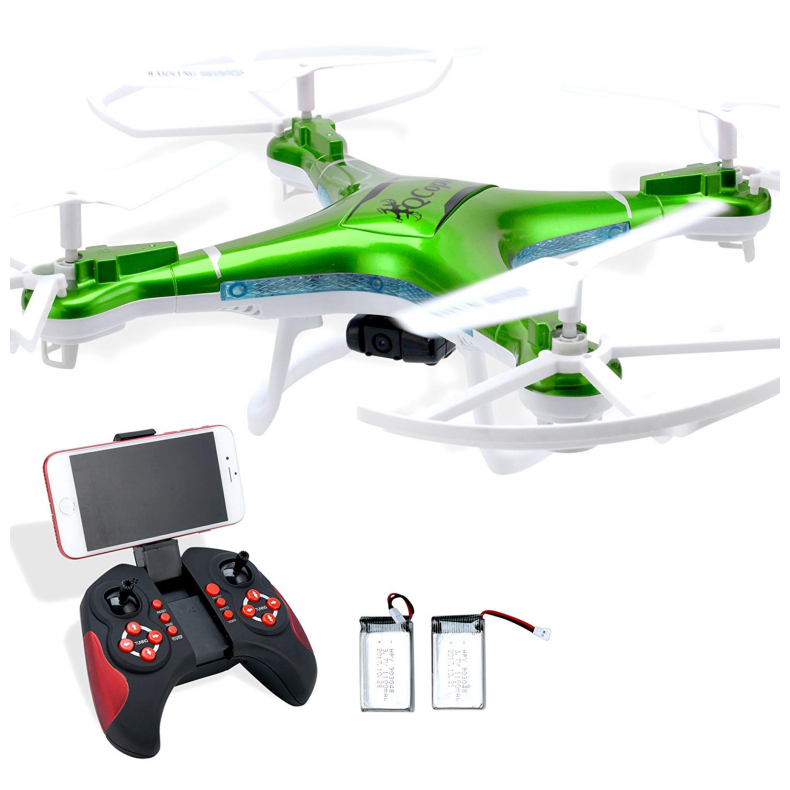

In [10]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 710 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 966.5, 393.5, -0.5)

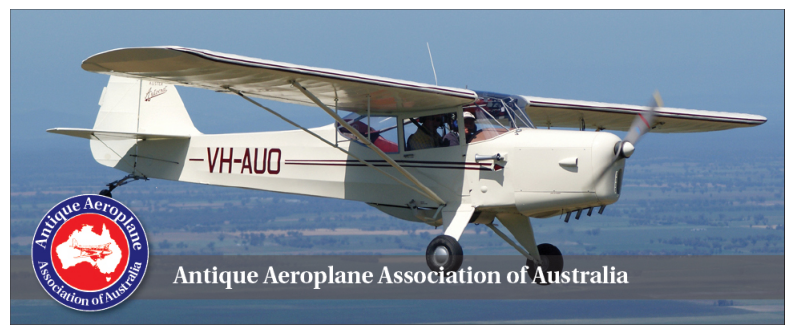

In [11]:
#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 418 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 3507.5, 2479.5, -0.5)

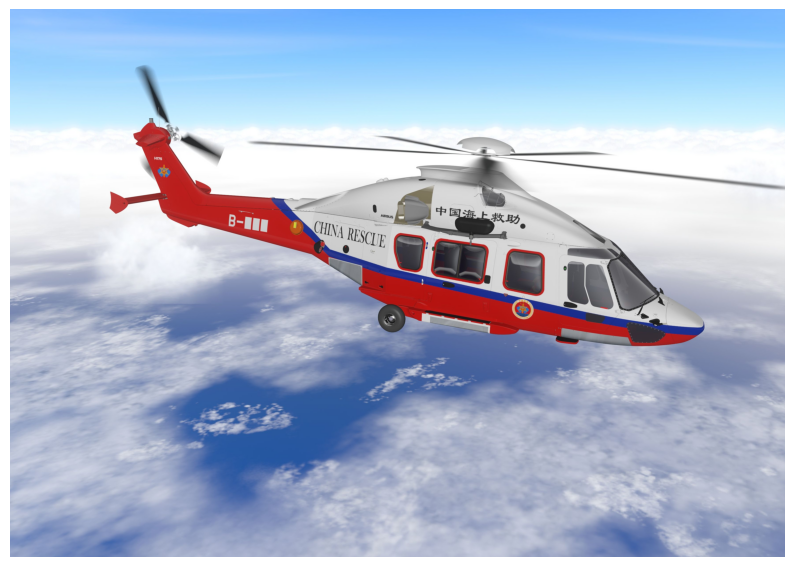

In [12]:
#@title Wybierz indeks przykładowego zdjęcia helikoptera ze zbioru treningowego:

idx = 631 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(helicopter_fnames))
img_path = os.path.join(train_helicopter_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

# Augmentacja danych

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=40,      # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

train_generator = train_datagen.flow_from_directory(directory=train_dir,      # scieżka do katalogu
                                                   target_size=(150, 150),    # rozmiar danych
                                                   batch_size=32,
                                                   class_mode='categorical')  # teraz categorical 👈👈👈✨


# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,      # scieżka do katalogu
                                                   target_size=(150, 150),    # rozmiar danych
                                                   batch_size=32,
                                                   class_mode='categorical')  # teraz categorical 👈👈👈✨

Found 2709 images belonging to 3 classes.
Found 774 images belonging to 3 classes.


# 👆 Sam rozpoznaje ilość klas po ilości katalogów w valid oraz train 👆

In [14]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

# Wyświetlenie jak zadziałała augmentacja danych

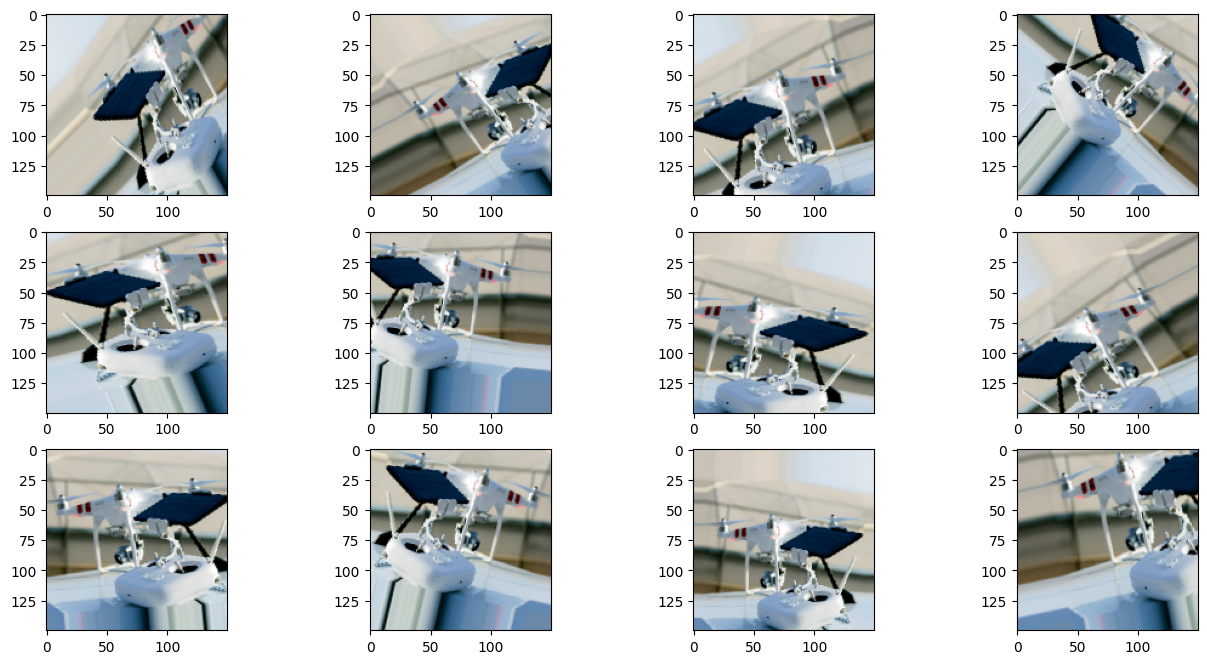

In [15]:
#@title Zbiór treningowy drone:
idx = 375 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_drone_dir, idx)

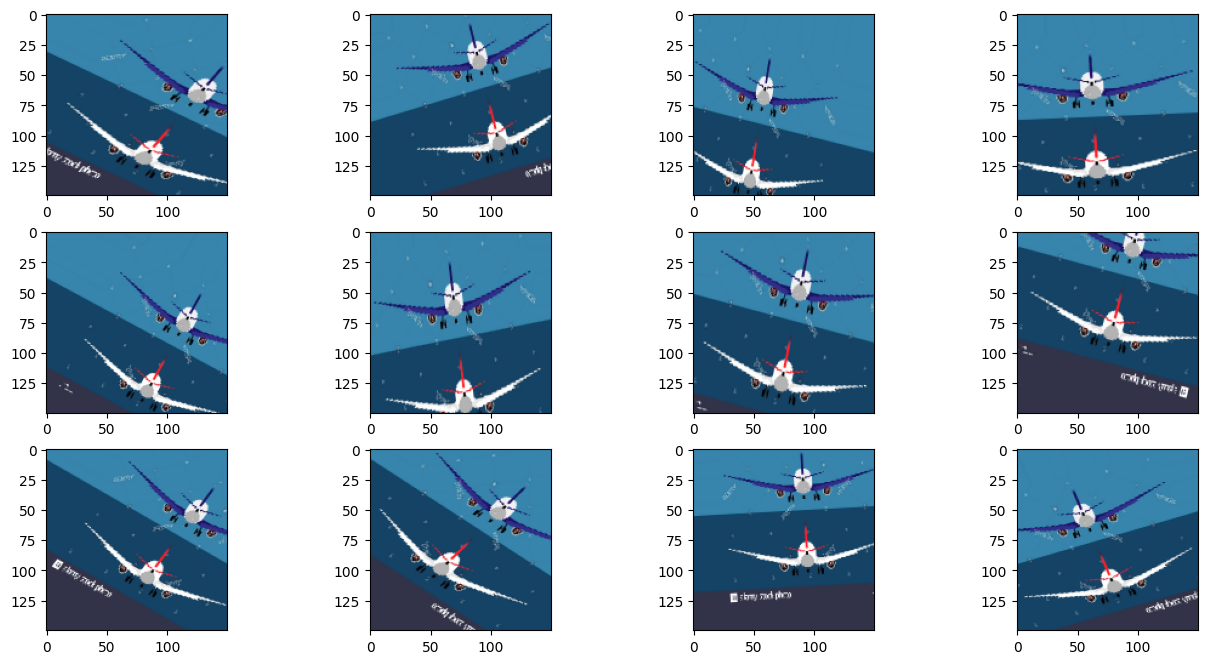

In [16]:
#@title Zbiór treningowy passenger:
idx = 777 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_passenger_dir, idx)

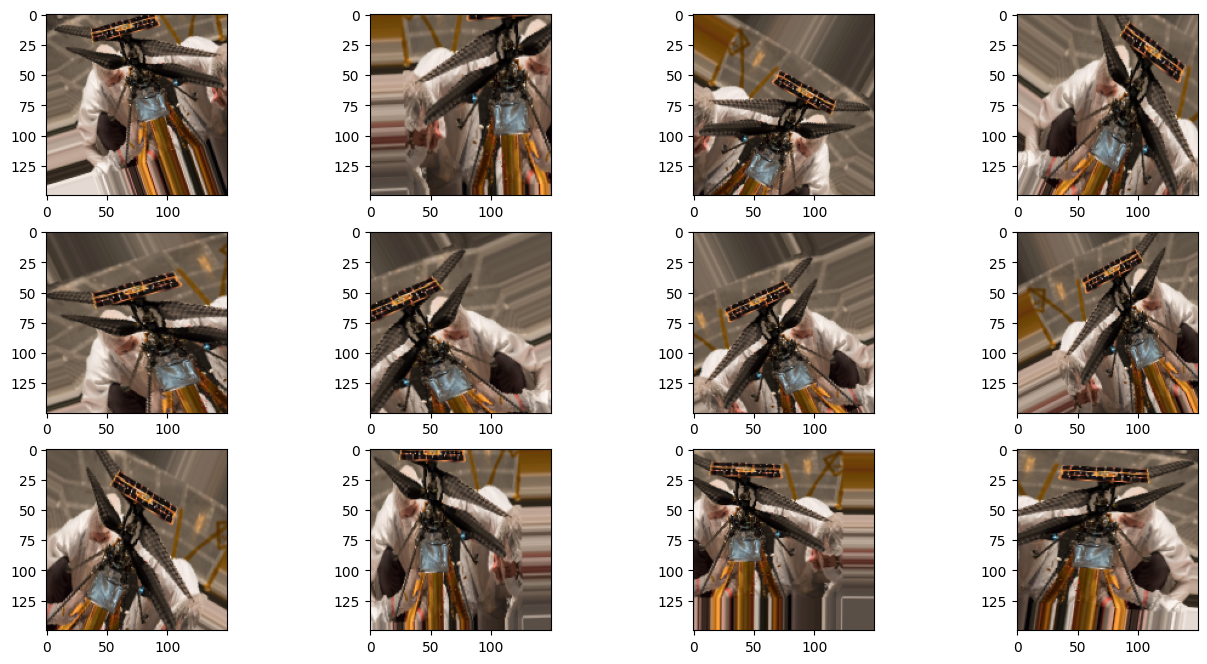

In [17]:
#@title Zbiór treningowy helicopter:
idx = 407 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_helicopter_dir, idx)

# Budowa modelu

In [18]:
batch_size = 32

steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

# Transfer learning - model VGG19 - odmrożenie ostatnich warstw

In [19]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

80134624/80134624 [==============================] - 0s 0us/step
layer_name: input_1       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_conv4  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_conv4  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [20]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_1       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_conv4  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_conv4  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [21]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())  # wypłaszcznie danych ✨
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))  # 3 -klasy oraz acivation softmax ponieważ mamy więcje niż diw klasy 👈👌

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),   # learning_rate !!!!!!!!🧨🧨🧨🧨 not lr !!!
             loss='categorical_crossentropy',           # categorical cross entopy 👈👌
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 22122563 (84.39 MB)
Trainable params: 11537411 (44.01 MB)
Non-trainable params: 10585152 (40.38 MB)
_________________________________________________________________


In [22]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=20,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

<ipython-input-22-c64e8bcc0c43>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/20
28/28 [==============================] - 26s 627ms/step - loss: 1.0556 - accuracy: 0.4475 - val_loss: 0.9205 - val_accuracy: 0.5938
Epoch 2/20
28/28 [==============================] - 20s 713ms/step - loss: 0.8958 - accuracy: 0.5966 - val_loss: 0.8114 - val_accuracy: 0.6367
Epoch 3/20
28/28 [==============================] - 18s 654ms/step - loss: 0.8272 - accuracy: 0.6417 - val_loss: 0.6899 - val_accuracy: 0.7031
Epoch 4/20
28/28 [==============================] - 17s 611ms/step - loss: 0.7466 - accuracy: 0.6663 - val_loss: 0.6474 - val_accuracy: 0.7070
Epoch 5/20
28/28 [==============================] - 18s 631ms/step - loss: 0.7578 - accuracy: 0.6607 - val_loss: 0.6163 - val_accuracy: 0.7227
Epoch 6/20
28/28 [==============================] - 19s 664ms/step - loss: 0.6697 - accuracy: 0.6998 - val_loss: 0.5754 - val_accuracy: 0.7539
Epoch 7/20
28/28 [==============================] - 18s 633ms/step - loss: 0.6212 - accuracy: 0.7444 - val_loss: 0.5897 - val_accuracy: 0.7461

In [23]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

# Ocena modelu na zbiorze testowym

In [24]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob

Found 387 images belonging to 3 classes.


<ipython-input-24-d5c8c634ffeb>:10: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([[0.929523, 0.003364, 0.067113],
       [0.887525, 0.04259 , 0.069885],
       [0.483203, 0.506101, 0.010696],
       ...,
       [0.11743 , 0.127603, 0.754967],
       [0.018644, 0.156674, 0.824682],
       [0.125171, 0.013534, 0.861295]], dtype=float32)

In [25]:
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0,
       0, 0, 2, 0, 2, 0, 2, 1, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 2, 2,
       2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2,
       2, 1, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,

In [26]:
predictions  = pd.DataFrame({'class': y_pred})
predictions

class
0        0
1        0
2        1
3        0
4        1
..     ...
382      2
383      2
384      2
385      2
386      2

[387 rows x 1 columns]

In [27]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [28]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0,
       0, 0, 2, 0, 2, 0, 2, 1, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 2, 2,
       2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2,
       2, 1, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,

In [29]:
test_generator.class_indices

{'drone': 0, 'helicopter': 1, 'passenger': 2}

In [30]:
classes = list(test_generator.class_indices.keys())
classes

['drone', 'helicopter', 'passenger']

In [31]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 79,   8,  42],
       [  7, 112,  10],
       [ 10,   4, 115]])

In [32]:
def plot_confusion_matrix(cm):
    # Mulitclass classification, 3 classes
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)

In [33]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

       drone       0.82      0.61      0.70       129
  helicopter       0.90      0.87      0.89       129
   passenger       0.69      0.89      0.78       129

    accuracy                           0.79       387
   macro avg       0.80      0.79      0.79       387
weighted avg       0.80      0.79      0.79       387



# Wyświetlenie błędów

In [34]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors

y_true  y_pred
drone/00000001.jpg           0       0
drone/00000006.jpg           0       0
drone/00000009.jpg           0       1
drone/00000022.jpg           0       0
drone/00000029.jpg           0       1
...                        ...     ...
passenger/00001453.jpg       2       2
passenger/00001454.jpg       2       2
passenger/00001477.jpg       2       2
passenger/00001484.jpg       2       2
passenger/00001488.jpg       2       2

[387 rows x 2 columns]

In [35]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

y_true  y_pred  is_incorrect
drone/00000001.jpg           0       0             0
drone/00000006.jpg           0       0             0
drone/00000009.jpg           0       1             1
drone/00000022.jpg           0       0             0
drone/00000029.jpg           0       1             1
...                        ...     ...           ...
passenger/00001453.jpg       2       2             0
passenger/00001454.jpg       2       2             0
passenger/00001477.jpg       2       2             0
passenger/00001484.jpg       2       2             0
passenger/00001488.jpg       2       2             0

[387 rows x 3 columns]

In [36]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000009.jpg', 'drone/00000029.jpg', 'drone/00000108.jpg',
       'drone/00000201.jpg', 'drone/00000233.png', 'drone/00000253.png',
       'drone/00000268.jpg', 'drone/00000409.jpg', 'drone/00000482.jpg',
       'drone/00000487.jpg', 'drone/00000504.jpg', 'drone/00000516.jpg',
       'drone/00000542.jpeg', 'drone/00000553.jpg', 'drone/00000565.jpg',
       'drone/00000593.jpg', 'drone/00000609.jpg', 'drone/00000650.jpg',
       'drone/00000761.jpg', 'drone/00000813.jpg', 'drone/00000833.jpg',
       'drone/00000867.jpg', 'drone/00000874.jpg', 'drone/00000882.jpeg',
       'drone/00000919.jpg', 'drone/00000957.jpg', 'drone/00000960.png',
       'drone/00000999.jpg', 'drone/00001003.jpg', 'drone/00001009.jpg',
       'drone/00001019.jpg', 'drone/00001026.jpg', 'drone/00001032.jpg',
       'drone/00001126.jpg', 'drone/00001129.jpg', 'drone/00001131.png',
       'drone/00001133.jpg', 'drone/00001134.jpg', 'drone/00001168.jpg',
       'drone/00001239.jpg', 'drone/00001245.jpg'

(-0.5, 734.5, 475.5, -0.5)

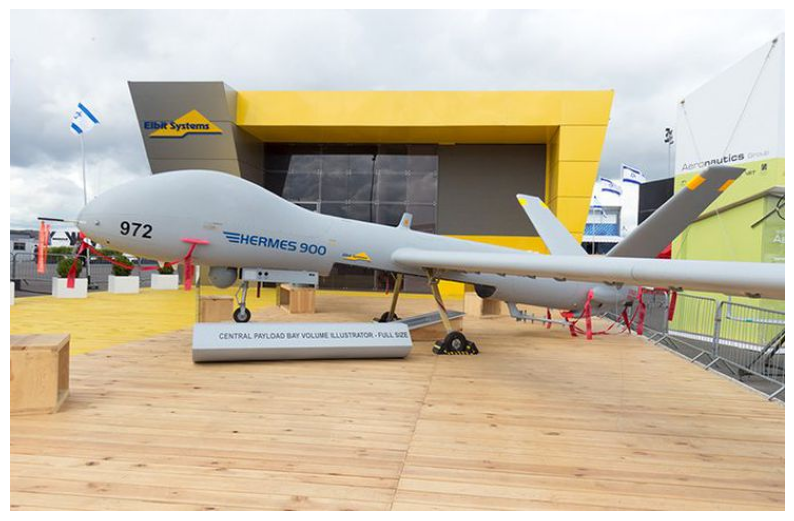

In [38]:
img_path = os.path.join(test_drone_dir, '00001026.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [39]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000009.jpg', 'drone/00000029.jpg', 'drone/00000108.jpg',
       'drone/00000201.jpg', 'drone/00000233.png', 'drone/00000253.png',
       'drone/00000268.jpg', 'drone/00000409.jpg', 'drone/00000482.jpg',
       'drone/00000487.jpg', 'drone/00000504.jpg', 'drone/00000516.jpg',
       'drone/00000542.jpeg', 'drone/00000553.jpg', 'drone/00000565.jpg',
       'drone/00000593.jpg', 'drone/00000609.jpg', 'drone/00000650.jpg',
       'drone/00000761.jpg', 'drone/00000813.jpg', 'drone/00000833.jpg',
       'drone/00000867.jpg', 'drone/00000874.jpg', 'drone/00000882.jpeg',
       'drone/00000919.jpg', 'drone/00000957.jpg', 'drone/00000960.png',
       'drone/00000999.jpg', 'drone/00001003.jpg', 'drone/00001009.jpg',
       'drone/00001019.jpg', 'drone/00001026.jpg', 'drone/00001032.jpg',
       'drone/00001126.jpg', 'drone/00001129.jpg', 'drone/00001131.png',
       'drone/00001133.jpg', 'drone/00001134.jpg', 'drone/00001168.jpg',
       'drone/00001239.jpg', 'drone/00001245.jpg'

(-0.5, 499.5, 374.5, -0.5)

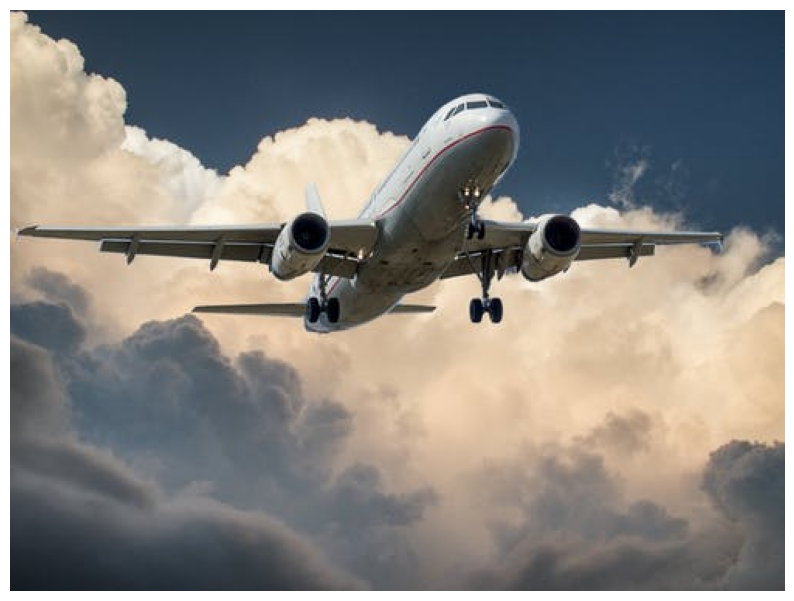

In [41]:
img_path = os.path.join(test_passenger_dir, '00000203.jpeg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [42]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000009.jpg', 'drone/00000029.jpg', 'drone/00000108.jpg',
       'drone/00000201.jpg', 'drone/00000233.png', 'drone/00000253.png',
       'drone/00000268.jpg', 'drone/00000409.jpg', 'drone/00000482.jpg',
       'drone/00000487.jpg', 'drone/00000504.jpg', 'drone/00000516.jpg',
       'drone/00000542.jpeg', 'drone/00000553.jpg', 'drone/00000565.jpg',
       'drone/00000593.jpg', 'drone/00000609.jpg', 'drone/00000650.jpg',
       'drone/00000761.jpg', 'drone/00000813.jpg', 'drone/00000833.jpg',
       'drone/00000867.jpg', 'drone/00000874.jpg', 'drone/00000882.jpeg',
       'drone/00000919.jpg', 'drone/00000957.jpg', 'drone/00000960.png',
       'drone/00000999.jpg', 'drone/00001003.jpg', 'drone/00001009.jpg',
       'drone/00001019.jpg', 'drone/00001026.jpg', 'drone/00001032.jpg',
       'drone/00001126.jpg', 'drone/00001129.jpg', 'drone/00001131.png',
       'drone/00001133.jpg', 'drone/00001134.jpg', 'drone/00001168.jpg',
       'drone/00001239.jpg', 'drone/00001245.jpg'

(-0.5, 749.5, 421.5, -0.5)

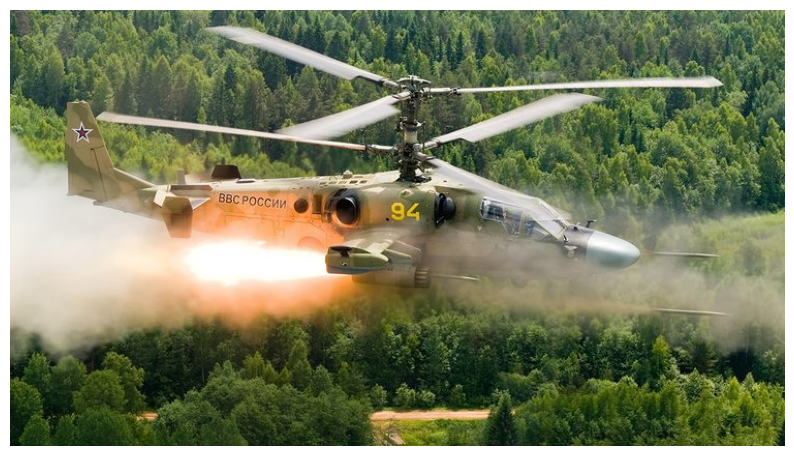

In [43]:
img_path = os.path.join(test_helicopter_dir, '00001245.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)